In [73]:
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
! ls

drive  sample_data  UNet.pt


# **Importing the required libraries**

In [75]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
!pip install torchvision=='0.11.1'
!pip install torch
import torch
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF

import random
import os, shutil
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

! pip install transformers
! pip install ml_collections
! pip install torchinfo

'''! 7z x "/content/drive/MyDrive/Hand Segmentation/train.zip" -o./dataset/train '-xr!__MACOSX'
! 7z x "/content/drive/MyDrive/Hand Segmentation/test.zip" -o./dataset/test '-xr!__MACOSX'
! mv dataset/train/train/* dataset/train/ && rm -rf dataset/train/train
! mv dataset/test/test/* dataset/test/ && rm -rf dataset/test/test
! cp "/content/drive/MyDrive/Hand Segmentation/sample_submission.csv" sample_submission.csv

! git clone https://github.com/adast/TransResUNet
! wget https://storage.googleapis.com/vit_models/imagenet21k/R50%2BViT-B_16.npz
'''
%matplotlib inline

import torchvision
torchvision.__version__
torch.__version__

'1.10.0+cu111'

In [76]:
torch.__version__

'1.10.0+cu111'

In [77]:
!ls drive/MyDrive/Tranresunet/

kaggle_3m  R50+ViT-B_16.npz  R50+ViT-L_32.npz  TranResunet.ipynb  TransResUNet



# **Setup Config class**

In [78]:
MODEL_TYPE = "UNET"
#LOSS = "ACT_CTR"
LOSS = "ACT_CTR"
IN_SIZE = (64, 64) #OVERRIDES THE CONFIG

class Config:   
    # data preprocessing
    data_dir = '/content/drive/My Drive/Tranresunet/kaggle_3m/'
    logdir = 'logdir'
    validation_fraction = 0.15
    test_fraction = 0.10
    train_batch = 16
    valid_batch = 32
    test_batch = 32
    
    # model setup
    input_dim = 256
    input_ch = 3
    output_dim = 256
    output_ch = 1
    
    # training
    seed = 21
    learning_rate = 3e-4
    epochs = 30
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# **Helper functions**

In [79]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
def plot_example(idx):
    base_path = os.path.join(Config.data_dir, test_df['directory'].iloc[idx])
    img_path = os.path.join(base_path, test_df['images'].iloc[idx])
    mask_path = os.path.join(base_path, test_df['masks'].iloc[idx])
    img = Image.open(img_path)
    mask = Image.open(mask_path)

    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    ax[0].imshow(img)
    ax[0].set_title('Image')
    ax[1].imshow(mask) 
    ax[1].set_title('Mask')
    plt.show()
    
def show_sample(sample, title=None):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(sample[0])
    ax[1].imshow(sample[1], cmap='gray')
    if title:
        fig.suptitle(title)
    plt.show()
    
def plot_predictions(model, idx):
    base_path = os.path.join(Config.data_dir, test_df['directory'].iloc[idx])
    img_path = os.path.join(base_path, test_df['images'].iloc[idx])
    mask_path = os.path.join(base_path, test_df['masks'].iloc[idx])

    img = Image.open(img_path)
    mask = Image.open(mask_path)

    tensor_img, tensor_mask = eval_transforms((img, mask))
    tensor_img = tensor_img.unsqueeze(0).to(Config.device) 
    
    model.eval()
    with torch.no_grad():
        pred = model(tensor_img)[0].detach().cpu().numpy()
        pred = pred.transpose((1, 2, 0)).squeeze()
        rounded = np.round(pred)
    
    plot_images = {'Image': img, 
                   'Mask': mask, 
                   'Predicted Mask': pred, 
                   'Predicted Rounded Mask': rounded}

    fig, ax = plt.subplots(1, 4, figsize=(16,4))
    for i, key in enumerate(plot_images.keys()):
        ax[i].imshow(plot_images[key])
        ax[i].set_title(key)
    plt.show()
    
set_seed(Config.seed)

# **Loading and exploring the data**

In [80]:
dirs, images, masks = [], [], []
for root, folders, files in os.walk(Config.data_dir):
    for file in files:
        # save only images with corresponding masks
        if 'mask'in file:
            dirs.append(root.replace(Config.data_dir, ''))
            masks.append(file)
            images.append(file.replace('_mask', ''))

PathDF = pd.DataFrame({'directory': dirs, 'images': images, 'masks': masks})
PathDF.head()

directory  ...                              masks
0  TCGA_HT_8114_19981030  ...  TCGA_HT_8114_19981030_11_mask.tif
1  TCGA_HT_8114_19981030  ...  TCGA_HT_8114_19981030_10_mask.tif
2  TCGA_HT_8114_19981030  ...  TCGA_HT_8114_19981030_17_mask.tif
3  TCGA_HT_8114_19981030  ...   TCGA_HT_8114_19981030_1_mask.tif
4  TCGA_HT_8114_19981030  ...  TCGA_HT_8114_19981030_18_mask.tif

[5 rows x 3 columns]

## **Train, test and validation split**

In [81]:
train2rest = Config.validation_fraction + Config.test_fraction
test2valid = Config.validation_fraction/train2rest

train_df, rest = train_test_split(
    PathDF, random_state=Config.seed,
    test_size=train2rest
)

test_df, valid_df = train_test_split(
    rest, random_state=Config.seed,
    test_size=test2valid
)

print('Train:', train_df.shape[0])
print('Valid:', valid_df.shape[0])
print('Test:', test_df.shape[0])

Train: 1547
Valid: 310
Test: 206


# **Visualization of the images and the masks**

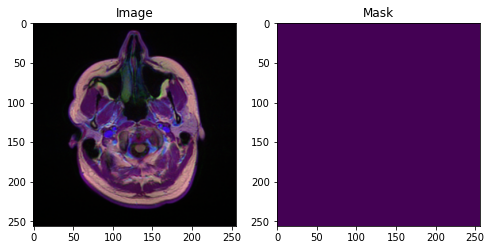

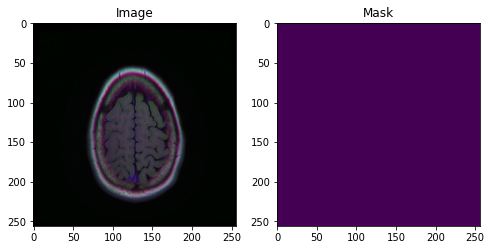

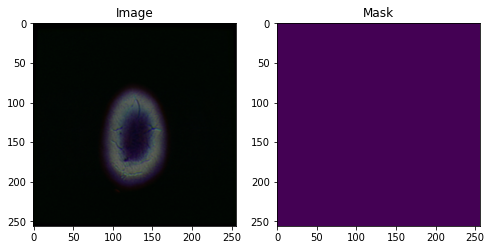

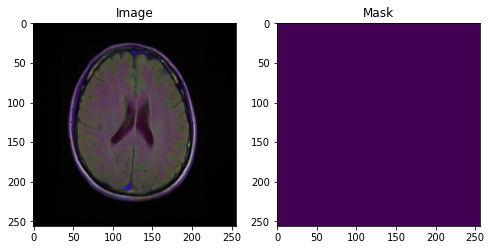

In [82]:
plot_example(69)
plot_example(123)
plot_example(24)
plot_example(34)

# **Dataset class**

In [83]:
class MRI_Dataset(Dataset):
    def __init__(self, path_df, transform=None):
        self.path_df = path_df
        self.transform = transform

    def __len__(self):
        return self.path_df.shape[0]

    def __getitem__(self, idx):
        base_path = os.path.join(Config.data_dir, self.path_df.iloc[idx]['directory'])
        img_path = os.path.join(base_path, self.path_df.iloc[idx]['images'])
        mask_path = os.path.join(base_path, self.path_df.iloc[idx]['masks'])

        image = Image.open(img_path)
        mask = Image.open(mask_path)

        sample = (image, mask)
        # apply the same transform on both image and a mask
        if self.transform:
            sample = self.transform(sample)

        return sample

# **Custom Transformations**

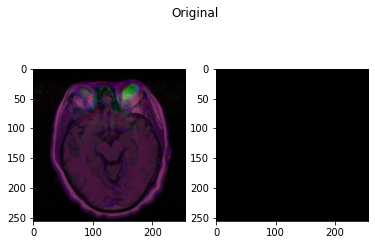

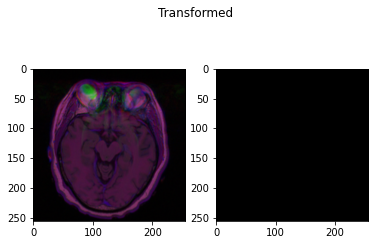

In [84]:
from PIL import Image


class PairedRandomHorizontalFlip():
    """Custom transform for horizontal flipping"""
    def __init__(self, prob=0.5):
        self.prob = prob   

    def __call__(self, sample):
        """
        Randomly flips both of the images

        Arguments:
        sample - tuple, image and segmentation mask
    
        Returns:
        (img, mask) - tuple, transformed sample
        """
        img, mask = sample
        if np.random.random() < self.prob:
            img, mask = TF.hflip(img), TF.hflip(mask)
        return img, mask
    
class PairedRandomAffine():
    """
    Randomly applies affine transformation
    on both of the images
    """
    def __init__(self, degrees=None, translate=None, scale_ranges=None, shears=None):

        self.params = {
            'degrees': degrees,
            'translate': translate,
            'scale_ranges': scale_ranges,
            'shears': shears
        }

    def __call__(self, sample):
        img, mask = sample
        w, h = img.size
        # extract parameters from trasnforms.RandomAffine
        angle, translations, scale, shear = transforms.RandomAffine.get_params(self.params['degrees'], self.params['translate'], self.params['scale_ranges'], self.params['shears'], (w,h))
        # apply TF.affine using fixed parameters
        img = TF.affine(img, angle, translations, scale, shear)
        mask = TF.affine(mask, angle, translations, scale, shear)
        return img, mask
    
class Resize():
    """
    Resize
    """
    def __init__(self, size=IN_SIZE):
        self.size = size
        self.resize = torchvision.transforms.Resize(size, interpolation=Image.NEAREST)
        
        
    def __call__(self, sample):
        img, mask = sample
        # extract parameters from trasnforms.RandomAffine
        img = self.resize(img)
        mask = self.resize(mask)
        return img, mask
    
class PairedToTensor():
    """
    Convert ndarrays in sample to Tensors.
    """
    def __call__(self, sample):
        img, mask = sample
        img = np.array(img)
        mask = np.expand_dims(mask, -1)
        img = np.moveaxis(img, -1, 0)
        mask = np.moveaxis(mask, -1, 0)
        img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
        img = img/255
        mask = mask/255
        return img, mask
    
dataset = MRI_Dataset(test_df)
sample = dataset[59]
transform = PairedRandomHorizontalFlip(prob=1)
show_sample(sample, title='Original')
show_sample(transform(sample), title='Transformed')

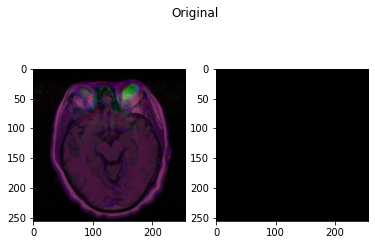

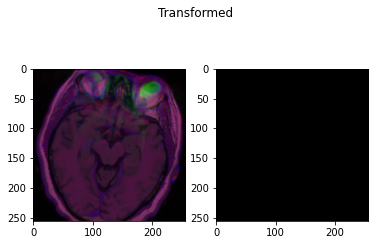

In [85]:
transform = PairedRandomAffine(
    degrees=(15, 15),
    scale_ranges=(1.2, 1.2)
) # for testing purposes we fix degrees and scale to a constant number
show_sample(sample, 'Original')
show_sample(transform(sample), 'Transformed')

# **Data transformation and loaders**

In [86]:
train_transforms = transforms.Compose([                       
    PairedRandomHorizontalFlip(), 
    PairedRandomAffine(
        degrees=(-15, 15),
        translate=(0.1, 0.1),
        scale_ranges=(0.8, 1.2)
    ),
    Resize(IN_SIZE),
    PairedToTensor()
])
eval_transforms = transforms.Compose([                       
    Resize(IN_SIZE),
    PairedToTensor()
])

train_data = MRI_Dataset(train_df, transform=train_transforms)
valid_data = MRI_Dataset(valid_df, transform=eval_transforms)
test_data = MRI_Dataset(test_df, transform=eval_transforms)

train_loader = DataLoader(train_data, batch_size=Config.train_batch, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_data, batch_size=Config.valid_batch, shuffle=False, num_workers=0)
test_loader = DataLoader(test_data, batch_size=Config.test_batch, shuffle=False, num_workers=0)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


# **Define the model**

In [87]:
import torch
import torchvision.ops
from torch import nn

class DeformableConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 bias=False):

        super(DeformableConv2d, self).__init__()
        
        assert type(kernel_size) == tuple or type(kernel_size) == int

        kernel_size = kernel_size if type(kernel_size) == tuple else (kernel_size, kernel_size)
        self.stride = stride if type(stride) == tuple else (stride, stride)
        self.padding = padding
        
        self.offset_conv = nn.Conv2d(in_channels, 
                                     2 * kernel_size[0] * kernel_size[1],
                                     kernel_size=kernel_size, 
                                     stride=stride,
                                     padding=self.padding, 
                                     bias=True)

        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)
        
        self.modulator_conv = nn.Conv2d(in_channels, 
                                     1 * kernel_size[0] * kernel_size[1],
                                     kernel_size=kernel_size, 
                                     stride=stride,
                                     padding=self.padding, 
                                     bias=True)

        nn.init.constant_(self.modulator_conv.weight, 0.)
        nn.init.constant_(self.modulator_conv.bias, 0.)
        
        self.regular_conv = nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=self.padding,
                                      bias=bias)

    def forward(self, x):
        #h, w = x.shape[2:]
        #max_offset = max(h, w)/4.

        offset = self.offset_conv(x)#.clamp(-max_offset, max_offset)
        modulator = 2. * torch.sigmoid(self.modulator_conv(x))
        
        x = torchvision.ops.deform_conv2d(input=x, 
                                          offset=offset, 
                                          weight=self.regular_conv.weight, 
                                          bias=self.regular_conv.bias, 
                                          padding=self.padding,
                                          mask=modulator,
                                          stride=self.stride,
                                          )
        return x
    

In [88]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, conv=nn.Conv2d):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential( 
            conv(in_ch, out_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            conv(out_ch, out_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
         )
    def forward(self, x):
        x = self.conv(x)
#         print("Double conv output: ", x.shape)
        return x

In [89]:
class InConv(nn.Module):
    def __init__(self, in_ch, out_ch, conv=nn.Conv2d):
        super(InConv, self).__init__()
        self.conv = DoubleConv(in_ch, out_ch, conv=conv)
    def forward(self, x):
        x = self.conv(x)
#         print("InConv conv output: ", x.shape)
        return x

In [90]:
class Down(nn.Module):
    def __init__(self, in_ch, out_ch, conv=nn.Conv2d):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential( 
            nn.MaxPool2d(2,2),
            DoubleConv(in_ch, out_ch, conv=conv)
         )
    def forward(self, x):
        x = self.mpconv(x)
#         print("Down conv output: ", x.shape)
        return x

In [91]:
class Up(nn.Module):
    def __init__(self, in_ch, out_ch, conv=nn.Conv2d):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch, conv=conv)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
#         print("Up conv output: ", x.shape)
        return x

In [92]:
# class OutConv(nn.Module):
#     def __init__(self, in_ch, out_ch, conv=nn.Conv2d):
#         super(OutConv, self).__init__()
#         self.conv = conv(in_ch, out_ch, 1, padding=0)
#         self.sigmoid = nn.Sigmoid()
#     def forward(self, x):
#         x = self.conv(x)
#         x = self.sigmoid(x)
# #         print("OutConv conv output: ", x.shape)
#         return x

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels, conv=nn.Conv2d):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid())
    def forward(self, x):
        return self.conv(x)

In [93]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes, conv=nn.Conv2d):
        super(UNet, self).__init__()
        self.inc = InConv(in_channels, 64, conv=conv)
        self.down1 = Down(64, 128, conv=conv)
        self.down2 = Down(128, 256, conv=conv)
        self.down3 = Down(256, 512, conv=conv)
        self.down4 = Down(512, 512, conv=conv)
        self.up1 = Up(1024, 256, conv=conv)
        self.up2 = Up(512, 128, conv=conv)
        self.up3 = Up(256, 64, conv=conv)
        self.up4 = Up(128, 64, conv=conv)
        self.outc = OutConv(64, num_classes, conv=conv)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [94]:
import sys
sys.path.insert(0, 'drive/MyDrive/Tranresunet/TransResUNet')
#from deformable_models import trans_resunet
from deformable_models.trans_resunet_deformable import TransResUNet

# Transformers
from transformers import AdamW, get_linear_schedule_with_warmup

# Pytorch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchinfo import summary

# Others
import ml_collections
import os
import glob
import math
import numpy as np
import pandas as pd
import random
from tqdm.notebook import tqdm
from PIL import Image

# Make computations repeatable
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# Compute on gpu if available
device = "cuda" if torch.cuda.is_available() else "cpu"





EPOCHS = 30
LEARNING_RATE = 5e-5

def get_r50_b16_config():
    config = ml_collections.ConfigDict()
    
    config.image_size = (64, 64)
    config.n_classes = 1
    #config.pre_trained_path = ''
    config.resnet = ml_collections.ConfigDict()
    # Using three bottleneck blocks results in a downscaling of 2^(1 + 3)=16 which
    # results in an effective patch size of /16.
    config.resnet.num_layers = (3, 4, 9)
    config.resnet.width_factor = 1
    
    config.transformer = ml_collections.ConfigDict()
    config.transformer.num_special_tokens = 1
    config.transformer.patch_size = 16
    config.transformer.hidden_size = 768
    config.transformer.mlp_dim = 3072
    config.transformer.num_heads = 12
    config.transformer.num_layers = 12
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1
    
    config.decoder = ml_collections.ConfigDict()
    config.decoder.head_channels = 512
    
    return config

def get_r50_l32_config():
    """Returns the ViT-L/32 configuration."""
    config = ml_collections.ConfigDict()
    
    config.image_size = (64, 64)
    config.n_classes = 1
    #config.pre_trained_path = ''
    
    config.resnet = ml_collections.ConfigDict()
    # Using four bottleneck blocks results in a downscaling of 2^(1 + 4)=32 which
    # results in an effective patch size of /32.
    config.resnet.num_layers = (3, 4, 6, 3)
    config.resnet.width_factor = 1
    
    config.transformer = ml_collections.ConfigDict()
    config.transformer.num_special_tokens = 1
    config.transformer.patch_size = 32
    config.transformer.hidden_size = 1024
    config.transformer.mlp_dim = 4096
    config.transformer.num_heads = 16
    config.transformer.num_layers = 24
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1
    
    config.decoder = ml_collections.ConfigDict()
    config.decoder.head_channels = 512
    
    return config

config = get_r50_b16_config()
model = TransResUNet(config)
model.to(device)

# Loss and optimizer
#criterion = nn.BCEWithLogitsLoss()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = len(train_loader),
    num_training_steps = total_steps
)

pre_trained_path is not specified, use this model with torch.load_state_dict only!


# **Train loop**

In [95]:
def train_loop(model, optimizer, criterion, train_loader, device=Config.device):
    running_loss = 0
    model.train()
    pbar = tqdm(train_loader, desc='Iterating over train data')
    for imgs, masks in pbar:
        # pass to device
        imgs = imgs.to(device)
        masks = masks.to(device)
        # forward
        out = model(imgs)
        if sigmoid_needed:
          out = nn.Sigmoid()(out)
#         print("imgs: ", imgs.shape)
#         print("masks: ", masks.shape)
#         print("out: ", out.shape)
        #print(out)
        loss = criterion(out, masks)
        running_loss += loss.item()*imgs.shape[0] 
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    running_loss /= len(train_loader.sampler)
    return running_loss

# **Evaluation loop**

In [96]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0
    return intersection / union


def iou_metric(inputs, target):
    intersection = np.logical_and(inputs, target)
    union = np.logical_or(inputs, target)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score


def Active_Contour_Loss(y_pred, y_true): 
    x = y_pred[:,:,1:,:] - y_pred[:,:,:-1,:] # horizontal and vertical directions 
    y = y_pred[:,:,:,1:] - y_pred[:,:,:,:-1]

    delta_x = x[:,:,1:,:-2]**2
    delta_y = y[:,:,:-2,1:]**2
    delta_u = torch.abs(delta_x + delta_y) 

    lenth = torch.mean(torch.sqrt(delta_u + 0.00000001)) # equ.(11) in the paper

    """
    region term
    """

    # C_1 = torch.ones((128, 128)).to(device)
    # C_2 = torch.zeros((128, 128)).to(device)

    # region_in = torch.abs(torch.mean( y_pred[:,0,:,:] * ((y_true[:,0,:,:] - C_1)**2) ) ) # equ.(12) in the paper
    # region_out = torch.abs(torch.mean( (1-y_pred[:,0,:,:]) * ((y_true[:,0,:,:] - C_2)**2) )) # equ.(12) in the paper
    region = nn.BCELoss()(y_pred, y_true)
    eta = 1
    lambdaP = 0.1 # lambda parameter could be various.
    mu = 1 # mu parameter could be various.
    
    return eta*(lambdaP* lenth + region)


In [97]:
def eval_loop(model, criterion, eval_loader, device=Config.device):
    global labelsx
    running_loss = 0
    model.eval()
    with torch.no_grad():
        accuracy, f1_scores = [], []
        dices, ious = [], []
        pbar = tqdm(eval_loader, desc='Iterating over evaluation data')
        for imgs, masks in pbar:
            # pass to device
            imgs = imgs.to(device)
            masks = masks.to(device)
            # forward
            out = model(imgs)
            if sigmoid_needed:
              out = nn.Sigmoid()(out)
            loss = criterion(out, masks)
            running_loss += loss.item()*imgs.shape[0]
            # calculate predictions using output
            predicted = (out > 0.5).float()
            predicted = predicted.view(-1).cpu().numpy()
            labels = masks.view(-1).cpu().numpy()
            accuracy.append(accuracy_score(labels, predicted))
            f1_scores.append(f1_score(labels, predicted))
            dices.append(dice_coef_metric(labels, predicted))
            ious.append(iou_metric(labels, predicted))
    acc = sum(accuracy)/len(accuracy)
    f1 = sum(f1_scores)/len(f1_scores)
    dice = sum(dices)/len(dices)
    iou = sum(ious)/len(ious)
    running_loss /= len(eval_loader.sampler)
    return {
        'accuracy':acc,
        'f1_macro':f1, 
        'loss':running_loss,
        'dice': dice,
        'iou': iou,
    }

# **Train the model**

In [98]:
def train(model, optimizer, criterion, train_loader, valid_loader,
          device=Config.device, 
          num_epochs=Config.epochs, 
          valid_loss_min=np.inf):
    
    for e in range(num_epochs):
        # train for epoch
        train_loss = train_loop(
            model, optimizer, criterion, train_loader, device=device)
        # evaluate on validation set
        metrics = eval_loop(
            model, criterion, valid_loader, device=device
        )
        # show progress
        print_string = f'Epoch: {e+1} '
        print_string+= f'TrainLoss: {train_loss:.5f} '
        print_string+= f'ValidLoss: {metrics["loss"]:.5f} '
        print_string+= f'ACC: {metrics["accuracy"]:.5f} '
        print_string+= f'F1: {metrics["f1_macro"]:.3f}'
        print_string+= f' Dice: {metrics["dice"]:.3f}'
        print_string+= f' IoU: {metrics["iou"]:.3f}'
        print(print_string)

        # save the model 
        if metrics["loss"] <= valid_loss_min:
            torch.save(model.state_dict(), 'UNet.pt')
            valid_loss_min = metrics["loss"]

In [99]:
def dice(input, target):
    smooth = 1.

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

In [100]:
set_seed(Config.seed)
sigmoid_needed = True
optimizer = optim.Adam(model.parameters(), lr=Config.learning_rate)
if LOSS == "CE":
    sigmoid_needed = False
    criterion =  nn.BCEWithLogitsLoss()
    print("CE")
elif LOSS == "ACT_CTR":
  criterion = Active_Contour_Loss
  print('Active_Ctr')
else:
    criterion = dice
    print('Dice')
print("Sigmoid Needed ",sigmoid_needed)

Active_Ctr
Sigmoid Needed  True


In [101]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [102]:
get_n_params(model)

109632065

In [103]:
model

TransResUNet(
  (transformer): HybridVit(
    (embeddings): Embeddings(
      (resnet): ResNetV2(
        (root): Sequential(
          (conv): StdConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (gn): GroupNorm(32, 64, eps=1e-06, affine=True)
          (relu): ReLU(inplace=True)
        )
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        (body): Sequential(
          (block1): ResNetStage(
            (units): Sequential(
              (unit1): ResidualUnit(
                (conv1): StdConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (gn1): GroupNorm(32, 64, eps=1e-06, affine=True)
                (conv2): StdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (gn2): GroupNorm(32, 64, eps=1e-06, affine=True)
                (conv3): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (gn3): GroupN

In [104]:
#344208641

In [105]:
train(model, optimizer, criterion, train_loader, valid_loader)

Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 TrainLoss: 0.12935 ValidLoss: 0.02719 ACC: 0.99253 F1: 0.643 Dice: 0.643 IoU: 0.480


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 2 TrainLoss: 0.02185 ValidLoss: 0.01933 ACC: 0.99377 F1: 0.717 Dice: 0.717 IoU: 0.564


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 3 TrainLoss: 0.01649 ValidLoss: 0.01710 ACC: 0.99419 F1: 0.735 Dice: 0.735 IoU: 0.585


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 4 TrainLoss: 0.01396 ValidLoss: 0.01285 ACC: 0.99549 F1: 0.821 Dice: 0.821 IoU: 0.698


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 5 TrainLoss: 0.01255 ValidLoss: 0.01250 ACC: 0.99565 F1: 0.827 Dice: 0.827 IoU: 0.706


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 6 TrainLoss: 0.01166 ValidLoss: 0.01294 ACC: 0.99569 F1: 0.835 Dice: 0.835 IoU: 0.718


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 7 TrainLoss: 0.01027 ValidLoss: 0.01258 ACC: 0.99539 F1: 0.830 Dice: 0.830 IoU: 0.709


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 8 TrainLoss: 0.01051 ValidLoss: 0.01098 ACC: 0.99612 F1: 0.840 Dice: 0.840 IoU: 0.727


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 9 TrainLoss: 0.01074 ValidLoss: 0.01169 ACC: 0.99595 F1: 0.832 Dice: 0.832 IoU: 0.714


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10 TrainLoss: 0.00956 ValidLoss: 0.01040 ACC: 0.99631 F1: 0.851 Dice: 0.851 IoU: 0.741


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 11 TrainLoss: 0.00887 ValidLoss: 0.00965 ACC: 0.99646 F1: 0.857 Dice: 0.857 IoU: 0.751


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 12 TrainLoss: 0.00951 ValidLoss: 0.01078 ACC: 0.99605 F1: 0.834 Dice: 0.834 IoU: 0.718


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 13 TrainLoss: 0.00883 ValidLoss: 0.00981 ACC: 0.99642 F1: 0.854 Dice: 0.854 IoU: 0.747


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 14 TrainLoss: 0.00848 ValidLoss: 0.00933 ACC: 0.99647 F1: 0.860 Dice: 0.860 IoU: 0.756


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 15 TrainLoss: 0.00835 ValidLoss: 0.00926 ACC: 0.99655 F1: 0.858 Dice: 0.858 IoU: 0.753


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 16 TrainLoss: 0.00826 ValidLoss: 0.00936 ACC: 0.99663 F1: 0.866 Dice: 0.866 IoU: 0.764


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 17 TrainLoss: 0.00809 ValidLoss: 0.00847 ACC: 0.99690 F1: 0.875 Dice: 0.875 IoU: 0.778


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 18 TrainLoss: 0.00792 ValidLoss: 0.00825 ACC: 0.99695 F1: 0.879 Dice: 0.879 IoU: 0.785


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 19 TrainLoss: 0.00771 ValidLoss: 0.00941 ACC: 0.99667 F1: 0.864 Dice: 0.864 IoU: 0.762


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 20 TrainLoss: 0.00756 ValidLoss: 0.00867 ACC: 0.99681 F1: 0.875 Dice: 0.875 IoU: 0.779


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 21 TrainLoss: 0.00779 ValidLoss: 0.00984 ACC: 0.99652 F1: 0.855 Dice: 0.855 IoU: 0.748


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 22 TrainLoss: 0.00753 ValidLoss: 0.00819 ACC: 0.99704 F1: 0.883 Dice: 0.883 IoU: 0.791


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 23 TrainLoss: 0.00734 ValidLoss: 0.00801 ACC: 0.99708 F1: 0.883 Dice: 0.883 IoU: 0.791


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 24 TrainLoss: 0.00731 ValidLoss: 0.00762 ACC: 0.99719 F1: 0.888 Dice: 0.888 IoU: 0.799


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 25 TrainLoss: 0.00692 ValidLoss: 0.00791 ACC: 0.99712 F1: 0.883 Dice: 0.883 IoU: 0.791


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 26 TrainLoss: 0.00701 ValidLoss: 0.00797 ACC: 0.99718 F1: 0.887 Dice: 0.887 IoU: 0.797


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 27 TrainLoss: 0.00709 ValidLoss: 0.00795 ACC: 0.99707 F1: 0.885 Dice: 0.885 IoU: 0.794


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 28 TrainLoss: 0.00701 ValidLoss: 0.00799 ACC: 0.99710 F1: 0.888 Dice: 0.888 IoU: 0.798


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 29 TrainLoss: 0.00671 ValidLoss: 0.00770 ACC: 0.99718 F1: 0.888 Dice: 0.888 IoU: 0.800


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 30 TrainLoss: 0.00657 ValidLoss: 0.00845 ACC: 0.99685 F1: 0.878 Dice: 0.878 IoU: 0.783


In [106]:
# Load the latest model
model.load_state_dict(torch.load('UNet.pt'))
metrics = eval_loop(model, criterion, train_loader)
print("SEARCH THIS STRING SEARCH SERCH SEARCH")


print('Train accuracy:', metrics['accuracy'])
print('Train f1 macro:', metrics['f1_macro'])
print('Train loss:', metrics['loss'])
print('Train IoU:', metrics['iou'])
print('Train Dice:', metrics['dice'])

metrics = eval_loop(model, criterion, test_loader)
print('Test accuracy:', metrics['accuracy'])
print('Test f1 macro:', metrics['f1_macro'])
print('Test loss:', metrics['loss'])
print('Test IoU:', metrics['iou'])
print('Test Dice:', metrics['dice'])

Iterating over evaluation data:   0%|          | 0/97 [00:00<?, ?it/s]

SEARCH THIS STRING SEARCH SERCH SEARCH
Train accuracy: 0.9976057000772462
Train f1 macro: 0.8747854601819912
Train loss: 0.006652128418248915
Train IoU: 0.7800862834666514
Train Dice: 0.8747854601819912


Iterating over evaluation data:   0%|          | 0/7 [00:00<?, ?it/s]

Test accuracy: 0.9981611602160395
Test f1 macro: 0.8797821950658403
Test loss: 0.005587212985508071
Test IoU: 0.7865445381146884
Test Dice: 0.8797821950658402


# **Visualizing the results**

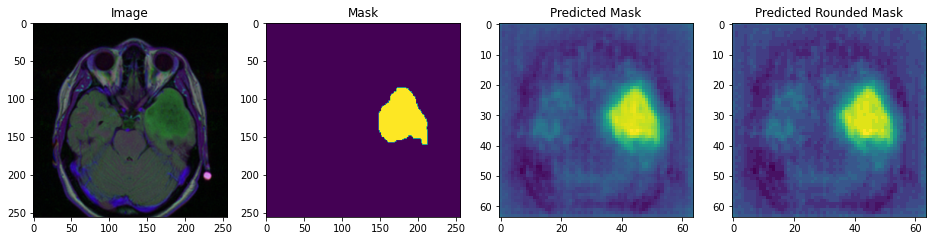

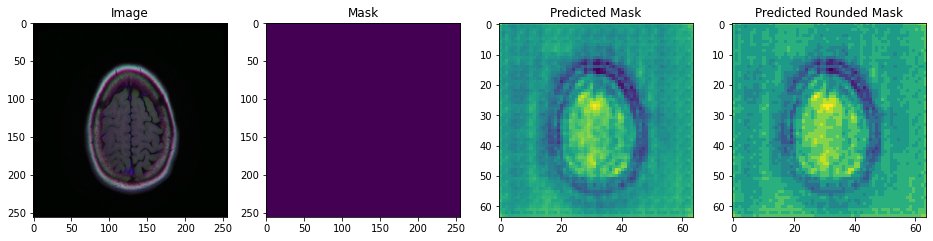

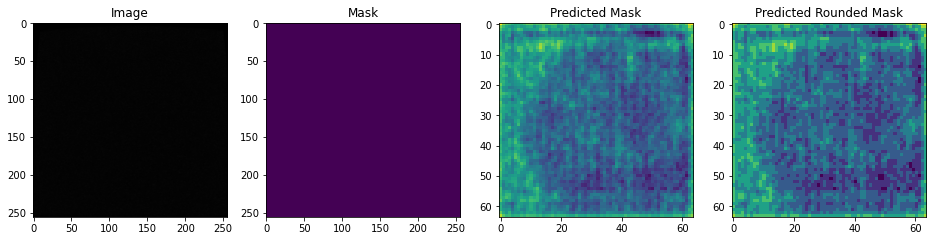

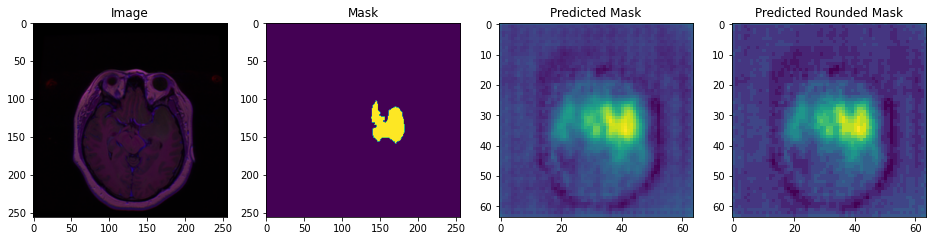

In [107]:
plot_predictions(model, 1)
plot_predictions(model, 123)
plot_predictions(model, 30)
plot_predictions(model, 35)

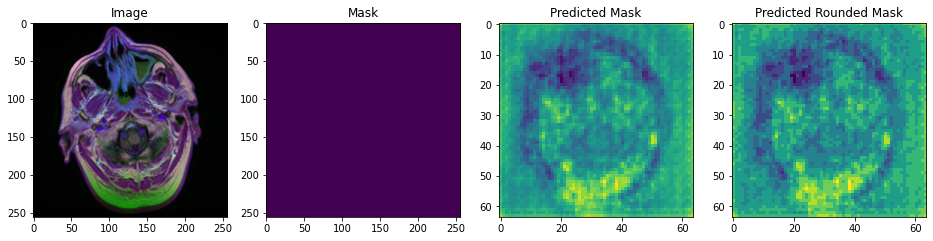

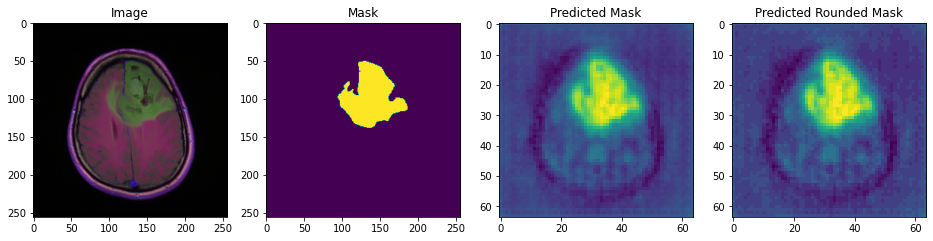

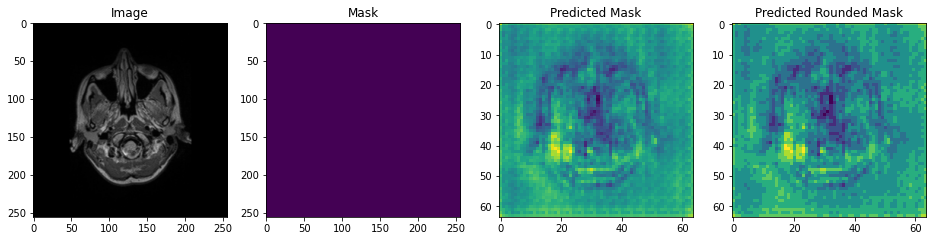

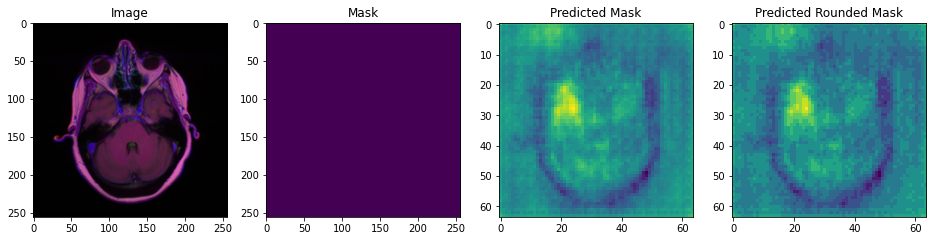

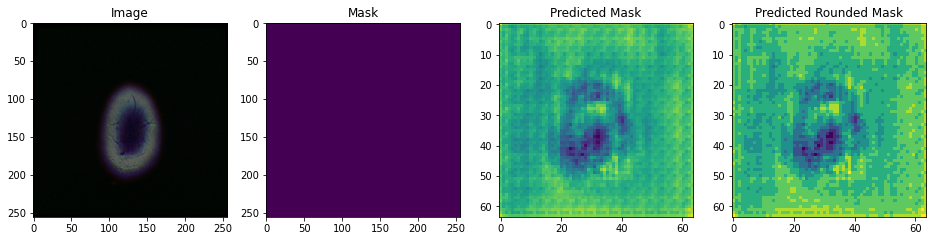

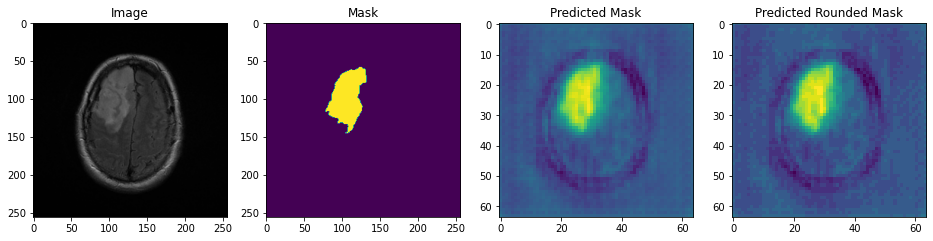

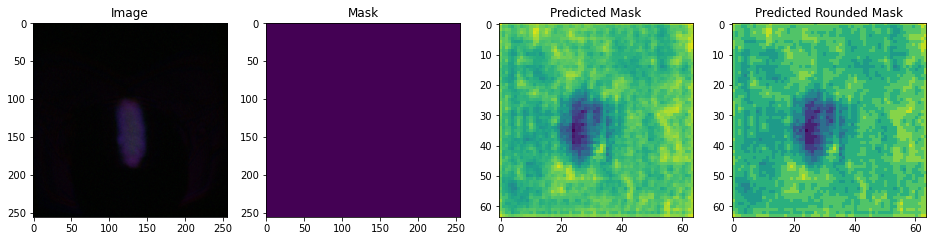

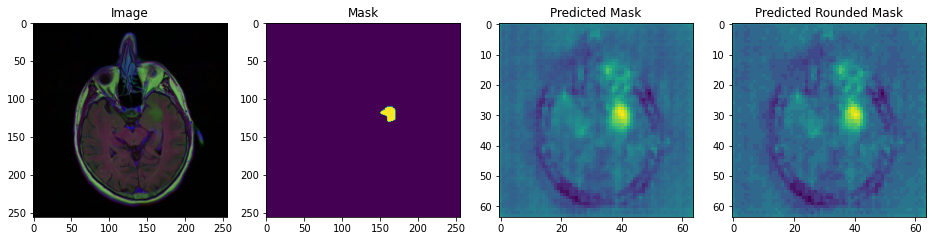

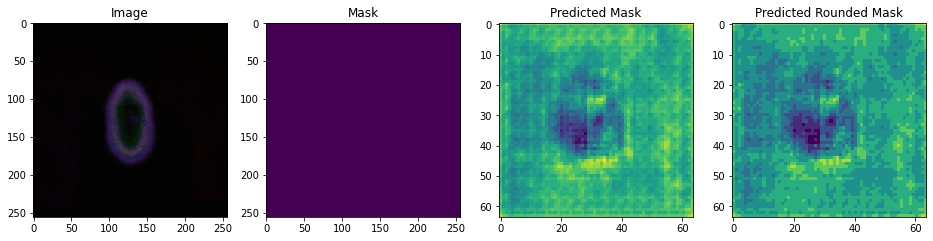

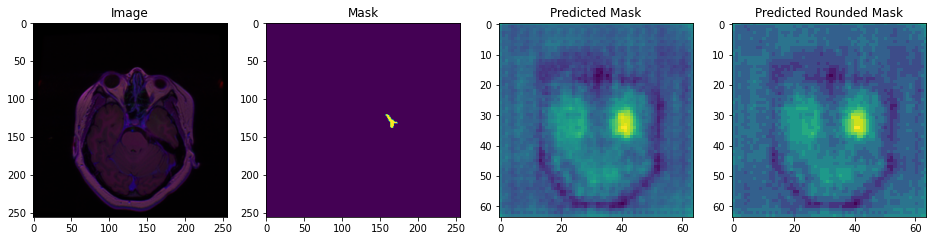

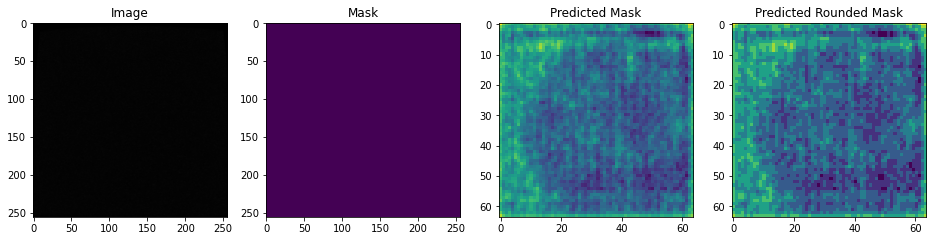

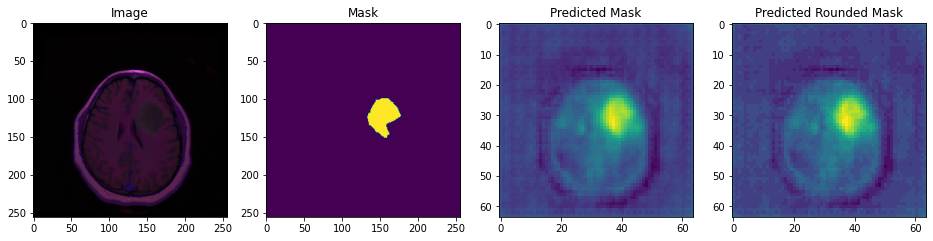

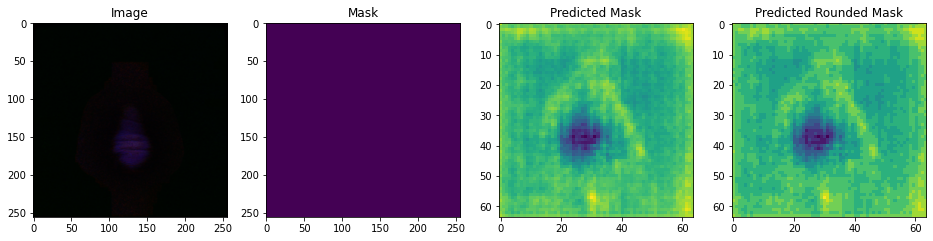

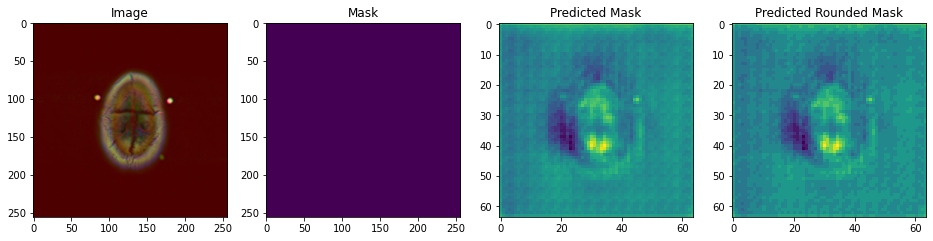

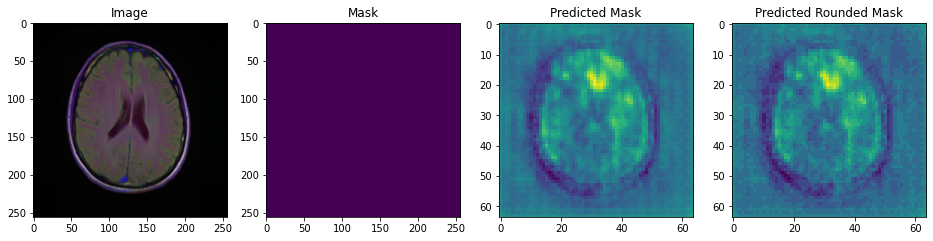

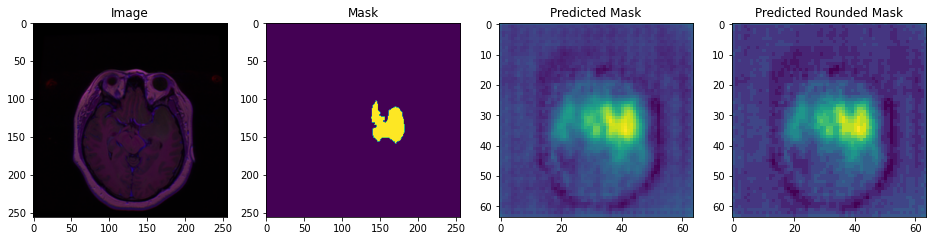

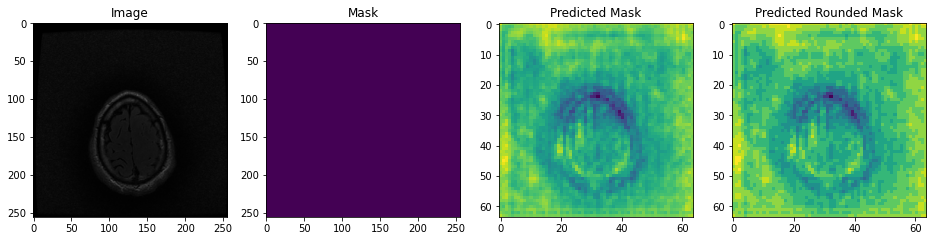

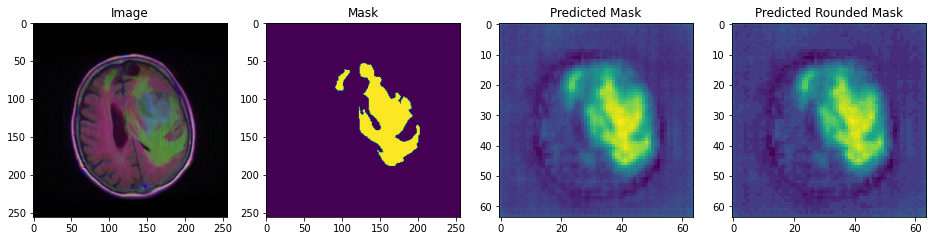

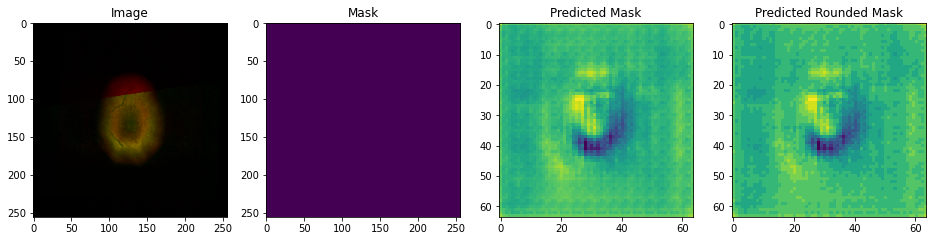

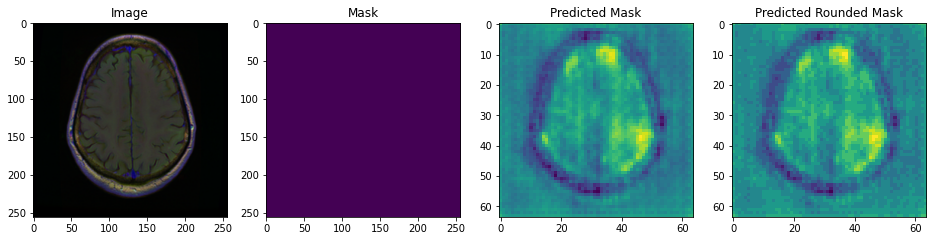

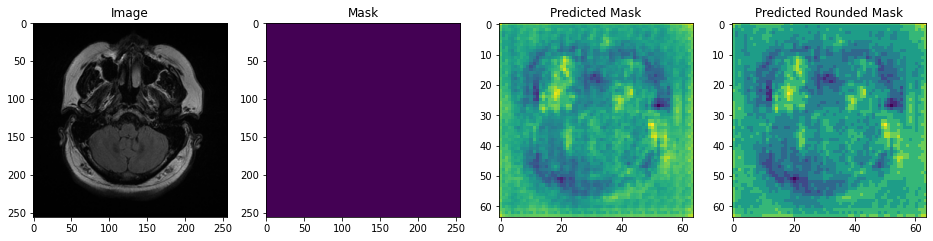

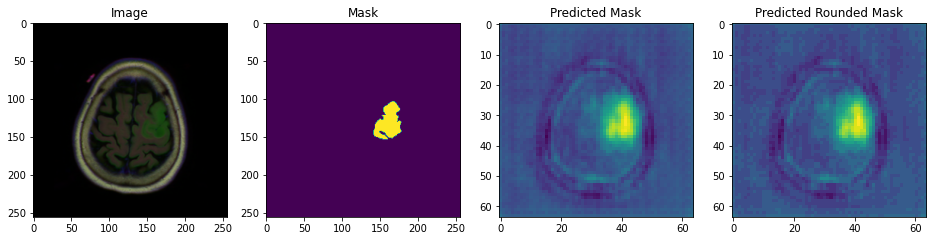

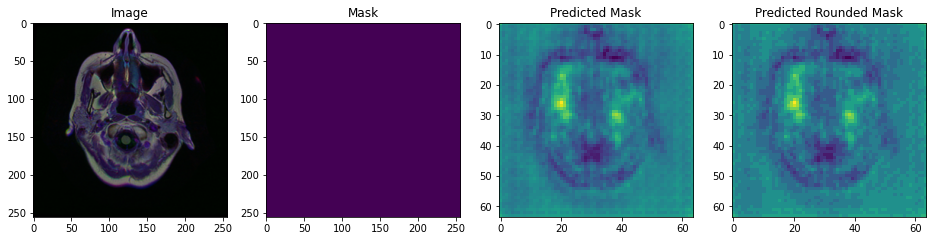

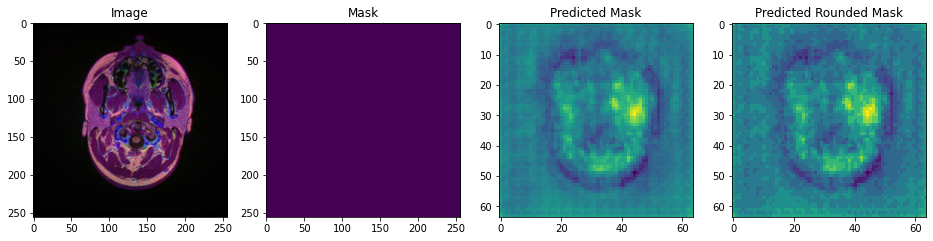

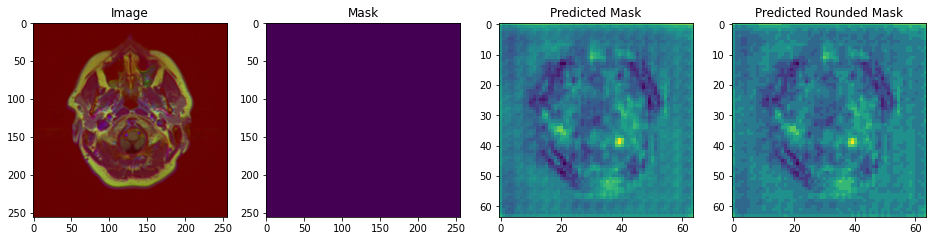

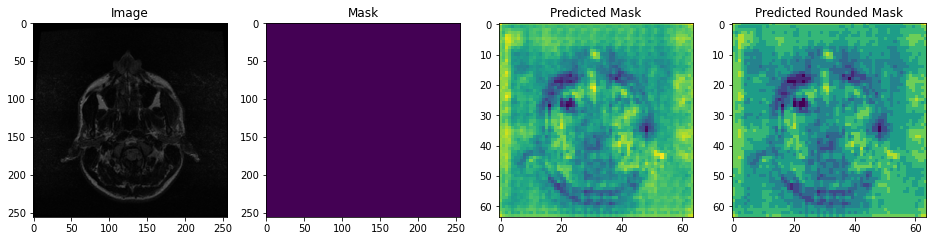

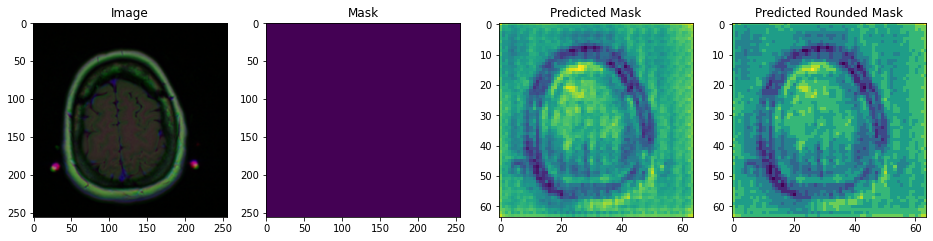

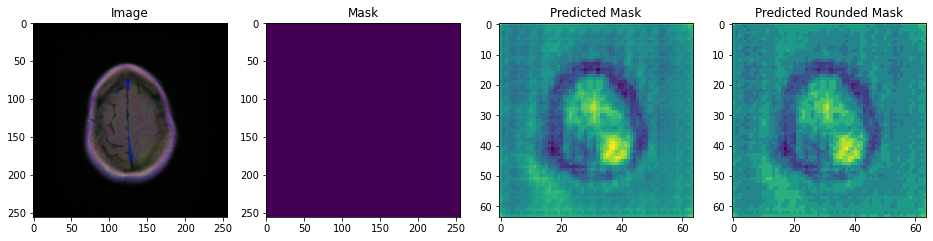

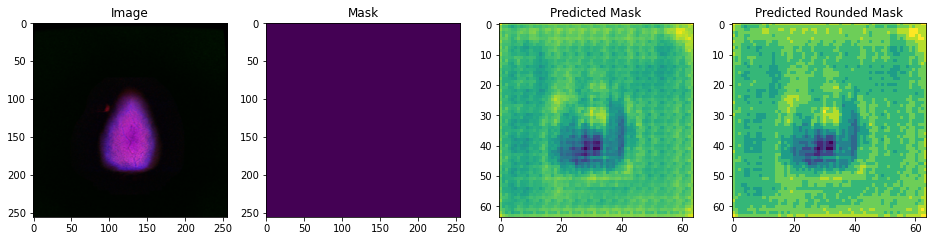

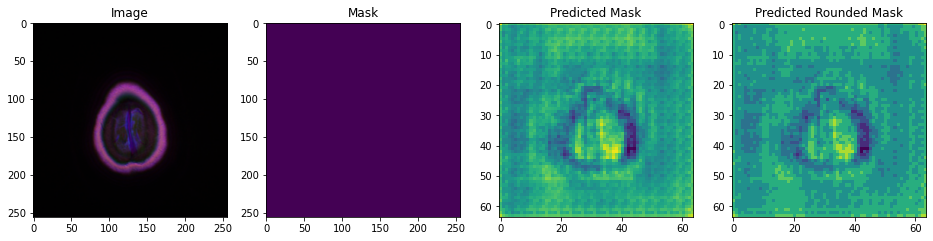

In [108]:
for i in range(20,50):
    plot_predictions(model, i)